In [75]:
import numpy as np
import tensorflow as tf
import matplotlib
import matplotlib.pyplot as plt
import scipy.misc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.feature_extraction import image
from PIL import Image
import threading
import time
import tqdm
import cv2

# Classes

In [76]:
class FaceFinder:
    def __init__(self):
        self.img = None
        self.img_orig = None
        self.patches = []
        self.preds = None

    def process_photo(self, img_name, patch_size=64):
        self.img = plt.imread(img_name)
        self.img = scipy.misc.imresize(self.img, (256, 256, 3))
        self.img = preprocess_image(self.img)
        self.img_orig = self.img.copy()

        self._split_pic_into_frames(size=patch_size)
        self._run_predictions()
        self._rectangify_patches()
        return self._gray_out()

    def _split_pic_into_frames(self, size, stride=1):
        sh_x = self.img.shape[0]
        sh_y = self.img.shape[1]
        len_x = size
        len_y = size
        stride_x = np.ceil(len_x*stride).astype(int)
        stride_y = np.ceil(len_y*stride).astype(int)

        for y in range(0, sh_y, stride_y):
            for x in range(0, sh_x, stride_x):
                patch = self.img[y:y+len_y, x:x+len_x]
                if patch.shape[0]*patch.shape[1]!=0:
                    self.patches.append([patch, (x, y), (x+len_x, y+len_y)])

    def _rectangify_patches(self):
        columns = int(np.sqrt(len(self.preds)))

        cont = True
        while cont:
            cont = False
            for r in range(columns-1):
                for c in range(columns-1):
                    if self.preds[r*columns+c] == 0:
                        LD = self.preds[(r+1)*columns+c-1]
                        SD = self.preds[(r+1)*columns+c]
                        RD = self.preds[(r+1)*columns+c+1]
                        L = self.preds[r*columns+c-1]
                        R = self.preds[r*columns+c+1]
                        LG = self.preds[(r-1)*columns+c-1]
                        SG = self.preds[(r-1)*columns+c]
                        RG = self.preds[(r-1)*columns+c+1]

                        answ = L*LD*SD + SD*RD*R + R*RG*SG + SG*LG*L

                        if answ >= 1:
                            cont = True
                            self.preds[r*columns+c] = 1

    def _gray_out(self):
        coord_start = np.array(self.patches)[:, 1]
        coord_end = np.array(self.patches)[:, 2]

        self.img.setflags(write=1)

        for start, end, pred in zip(coord_start, coord_end, self.preds):
            if pred < 0.5:
                self.img[max(0, start[0]-3):end[0]+3, max(0, start[1]-3):end[1]+3] = [255, 0, 0]

        for start, end, pred in zip(coord_start, coord_end, self.preds):
            R = self.img_orig[start[0]:end[0], start[1]:end[1]][:, :, 0]
            G = self.img_orig[start[0]:end[0], start[1]:end[1]][:, :, 1]
            B = self.img_orig[start[0]:end[0], start[1]:end[1]][:, :, 2]
            if pred < 0.5:
                self.img[start[0]:end[0], start[1]:end[1]][:, :, 0] = R
                self.img[start[0]:end[0], start[1]:end[1]][:, :, 1] = G
                self.img[start[0]:end[0], start[1]:end[1]][:, :, 2] = B

        return self.img, self.img_orig

    def _run_predictions(self):
        a = scipy.misc.imresize(self.patches[0][0], (64, 64, 3)).reshape((1, 64, 64, 3))
        for i in self.patches[1:]:
            a = np.vstack((a, scipy.misc.imresize(i[0], (64, 64, 3)).reshape((1, 64, 64, 3))))
        self.preds = predict(a, sess)


# Model variables

In [77]:
epochs = 5
shape = (64, 64, 3)

## Prepare data

In [78]:
def preprocess_image(img):
#     v = np.median(img)

#     # apply automatic Canny edge detection using the computed median
#     lower = int(max(0, (1.0 - 0.33) * v))
#     upper = int(min(255, (1.0 + 0.8) * v))
#     img = cv2.Canny(img, lower, upper)
#     img = img.astype(np.float32)
#     img /= 255
    
    return img

In [79]:
def split_pic(img):
    img = preprocess_image(img)
    face = []
    background = []
    
    img_shape = 256
    
    length = 64 
    stride = 64
    
    for y_coord in range(0, img_shape, stride):
        for x_coord in range(0, img_shape, stride):
            patch = img[y_coord:y_coord+length, x_coord:x_coord+length]
            if y_coord>=64 and y_coord+length<=192 and x_coord>=64 and x_coord+length<=192:
                face.append(patch)
            else:
                background.append(patch)
    face.append(scipy.misc.imresize(img[64:128, 64:128], shape))
    
    return face, background

In [80]:
def prepare_data(images_list, resize_size=(256, 256, 3)):
    raw_images = [plt.imread(i) for i in images_list]
    raw_images = [scipy.misc.imresize(i, resize_size) for i in raw_images]
    
    faces = []
    background = []
    for i in raw_images:
        f, b = split_pic(i)
        faces.append(f)
        background.append(b)

    background = np.array(background).reshape(len(raw_images)*12, *shape)
    faces = np.array(faces).reshape(len(raw_images)*5, *shape)
    y = [[1] for i in range(len(faces))]
    y.extend([[0] for i in range(len(background))])

    return np.concatenate([faces, background]), y

In [81]:
with open('Faces/files_list.txt') as f:
    face_files_list = f.readlines()
    
images_list = [i.strip() for i in face_files_list] 
X, y = prepare_data(images_list)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42);

C:\Program Files\Anaconda3\lib\site-packages\scipy\misc\pilutil.py:482: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if issubdtype(ts, int):
C:\Program Files\Anaconda3\lib\site-packages\scipy\misc\pilutil.py:485: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif issubdtype(type(size), float):


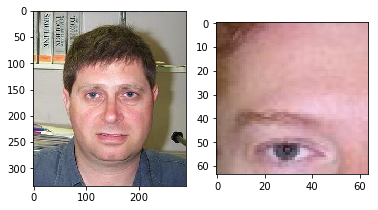

In [82]:
index = int(np.random.random(1)*len(X_train))
img = plt.imread(images_list[0])
img = preprocess_image(img)

plt.subplot(121)
plt.imshow(img)
plt.subplot(122)
plt.imshow(X_train[index])
plt.show()

# Craft and fit model

## Queue-based network

In [83]:
def architecture(inputs):
    inputs = tf.cast(inputs, tf.float32)
    
    # ARCHITECTURE
    with tf.name_scope("convolutional"):
        conv1 = tf.layers.conv2d(
                    inputs=inputs,
                    filters=32,
                    kernel_size=3,
                    padding='same',
                    activation=tf.nn.relu)
        pool1 = tf.layers.max_pooling2d(inputs=conv1, pool_size=2, strides=2)

        conv2 = tf.layers.conv2d(
                    inputs=pool1,
                    filters=32,
                    kernel_size=3,
                    padding='same',
                    activation=tf.nn.relu)
        pool2 = tf.layers.max_pooling2d(inputs=conv2, pool_size=2, strides=2)

        conv3 = tf.layers.conv2d(
                    inputs=pool2,
                    filters=64,
                    kernel_size=3,
                    padding='same',
                    activation=tf.nn.relu)
        pool3 = tf.layers.max_pooling2d(inputs=conv3, pool_size=2, strides=2)   
        flatten = tf.reshape(pool3, [-1, int((shape[0]/8)*(shape[1]/8)*64)])  

    with tf.name_scope("dense"):
        dense1 = tf.layers.dense(
                    inputs=flatten,
                    units=512)
        dense1_batch = tf.layers.batch_normalization(dense1, training=True)
        dense1_relu = tf.nn.relu(dense1_batch)

        dense2 = tf.layers.dense(
                    inputs=dense1_relu,
                    units=256,
                    activation=tf.nn.relu)

        dense3 = tf.layers.dense(
                    inputs=dense2,
                    units=128)
        dense3_batch = tf.layers.batch_normalization(dense3, training=True)
        dense3_relu = tf.nn.relu(dense3_batch)

        dense4 = tf.layers.dense(
                    inputs=dense3_relu,
                    units=64,
                    activation=tf.nn.relu)

    with tf.name_scope("logits"):
        logits = tf.layers.dense(inputs=dense4, units=2)
    return logits

In [84]:
def predict_proba(X, sess):
    pred_x = tf.convert_to_tensor(X, dtype=np.float32)

    with sess.as_default():
        with tf.variable_scope("output", reuse=True) as scope:
            logits = architecture(pred_x)
            predictions = tf.nn.softmax(logits)
    
        return predictions.eval()

def predict(X, sess):
    result = predict_proba(X, sess)
    return np.argmax(result, axis=1)

In [85]:
def evaluate(X, y, sess):
    n_iterations = int(np.ceil(len(X) / 64))
    predictions = []
    
    for i in tqdm.trange(n_iterations):
        predictions += predict(X[i*64:(i+1)*64], sess).tolist()
        
    sums = 0
    for i in range(len(predictions)):
        if [predictions[i]] == y[i]:
            sums += 1
            
    return sums, accuracy_score(predictions, y)

In [86]:
def fit(X, y, X_test, y_test):
    coord = tf.train.Coordinator()
    n_iterations = int(np.ceil(len(X) / 64))
    
    def next_train_batch(X, y):
        batch_x = tf.constant(X, dtype=tf.float32, shape=(len(X), *shape))
        batch_y = tf.constant(y, dtype=tf.int32, shape=[len(X)])

        return [batch_x, batch_y]
    
    with tf.name_scope('train_input'):
        batch_x, batch_y = tf.train.shuffle_batch(
            next_train_batch(X, y),
            enqueue_many=True,
            batch_size=64,
            capacity=10,
            min_after_dequeue=5)
        
    with tf.variable_scope('output'):
        logits = architecture(batch_x)
    
    with tf.name_scope('train'):
        batch_y = tf.cast(batch_y, tf.int32)
        
        loss = tf.losses.sparse_softmax_cross_entropy(labels=batch_y, logits=logits)
        train_op = tf.train.AdamOptimizer().minimize(loss=loss, global_step=tf.train.get_global_step())
        
    with sess.as_default():
        init = [tf.global_variables_initializer(), tf.local_variables_initializer()]
        sess.run(init)
        
        threads = tf.train.start_queue_runners(sess=sess, coord=coord)
        
        for epoch in range(5):
            loss_sum = 0
            for i in tqdm.trange(n_iterations):               
                _, ls = sess.run([train_op, loss])
                loss_sum += ls
            print('Training loss: %f' % (loss_sum/n_iterations))
            
        num, acc = evaluate(X_test, y_test, sess)
        print('Accuracy: %.3f : %i/%i' % (acc, num, len(y_test)))

        coord.request_stop()
        coord.join(threads)

In [87]:
print(len(X_train))
print(len(X_test))

5916
1479


In [88]:
tf.reset_default_graph()
sess = tf.Session()
fit(X_train, y_train, X_test, y_test)

100%|██████████████████████████████████████████████████████████████| 93/93 [01:06<00:00,  1.39it/s]


Training loss: 0.149331


100%|██████████████████████████████████████████████████████████████| 93/93 [00:54<00:00,  1.72it/s]


Training loss: 0.089965


100%|██████████████████████████████████████████████████████████████| 93/93 [00:50<00:00,  1.84it/s]


Training loss: 0.062542


100%|██████████████████████████████████████████████████████████████| 93/93 [00:51<00:00,  1.81it/s]


Training loss: 0.052195


100%|██████████████████████████████████████████████████████████████| 93/93 [00:46<00:00,  1.98it/s]


Training loss: 0.041092


100%|██████████████████████████████████████████████████████████████| 24/24 [00:27<00:00,  1.15s/it]


Accuracy: 0.980 : 1449/1479


## Graph exporting

In [37]:
# writer = tf.summary.FileWriter('logs', sess.graph)
# print(sess.run(logits, feed_dict={features: [X[0]], labels: [y[0]]}))
# writer.close()

In [38]:
# predictions = sess.run(ar_max, feed_dict={features: X, labels: y})

# conf = confusion_matrix(y, predictions)
# print(conf)

# Face location

C:\Program Files\Anaconda3\lib\site-packages\scipy\misc\pilutil.py:482: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if issubdtype(ts, int):
C:\Program Files\Anaconda3\lib\site-packages\scipy\misc\pilutil.py:485: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif issubdtype(type(size), float):


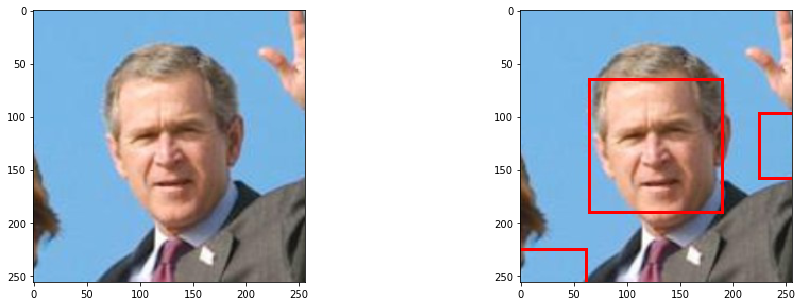

In [89]:
facefinder = FaceFinder()
img, img_orig = facefinder.process_photo('George_W_Bush/George_W_Bush_0142.jpg', patch_size=32)

plt.figure(figsize=(16, 5))
plt.subplot(121)
plt.imshow(img_orig)
plt.subplot(122)
plt.imshow(img)
plt.show()

In [ ]:
def freeze_session(session, keep_var_names=None, output_names=None, clear_devices=True):
    from tensorflow.python.framework.graph_util import convert_variables_to_constants
    graph = session.graph
    with graph.as_default():
        freeze_var_names = list(set(v.op.name for v in tf.global_variables()).difference(keep_var_names or []))
        output_names = output_names or []
        output_names += [v.op.name for v in tf.global_variables()]
        input_graph_def = graph.as_graph_def()
        if clear_devices:
            for node in input_graph_def.node:
                node.device = ""
        frozen_graph = convert_variables_to_constants(session, input_graph_def,
                                                      output_names, freeze_var_names)
        return frozen_graph

In [ ]:
frozen_graph = freeze_session(keras.backend.get_session(), output_names=[model.output.op.name])

In [ ]:
tf.train.write_graph(frozen_graph, "frozen_model", "model.pb", as_text=False)

checkpoint = tf.train.get_checkpoint_state('./frozen/')
input_checkpoint = checkpoint.model_checkpoint_path

absolute_model_dir = "/".join(input_checkpoint.split('/')[:-1])
output_graph = absolute_model_dir + "/frozen_model.pb"

clear_devices = True

with tf.Session(graph=tf.Graph()) as sess:
    saver = tf.train.import_meta_graph(input_checkpoint + '.meta', clear_devices=clear_devices)

    saver.restore(sess, input_checkpoint)

    output_graph_def = tf.graph_util.convert_variables_to_constants(
        sess,
        tf.get_default_graph().as_graph_def(),
        ['activation_7/Softmax']
    ) 

    with tf.gfile.GFile(output_graph, "wb") as f:
        f.write(output_graph_def.SerializeToString())
    print("%d ops in the final graph." % len(output_graph_def.node))